In [1]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(
    fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

# 선형 회귀 모델 훈련
- 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 대해 비용함수를 최소화하는 모델 파라미터를 해석적으로 구한다.
- 경사 하강법이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용함수를 훈련 세트에 대해 최소화 시킨다.

# 정규방정식
- 비용 함수를 최소화하는 세터 값을 찾기 위한 해석적인 방법

선형처럼 보이는 데이터 생성

In [2]:
import numpy as np
np.random.seed(42)
X = 2*np.random.rand(100, 1)
y = 4+3*X+np.random.randn(100,1)

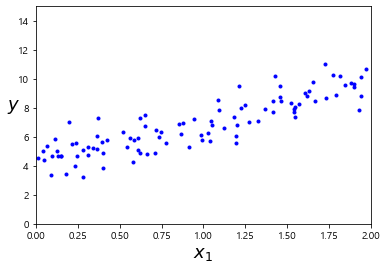

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(X,y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

정규방정식 사용

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가 
# np.c_ : 열에 대하여 분리된 것을 연결 시켜줌
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

theta_0 = 4.215, theta_1 = 2.770 대신 4와 3을 기대했지만 노이즈 때문에 원래 함수의 파라미터를 정확히 재현하지 못함

### theta_hat 사용해 예측

In [5]:
X_new = np.array([[0],[2]])
print(X_new)
print("========")
X_new_b = np.c_[np.ones((2, 1)), X_new] # 모든 샘플에 x0 = 1을 추가
print(X_new_b)
y_predict=X_new_b.dot(theta_best)
y_predict

[[0]
 [2]]
[[1. 0.]
 [1. 2.]]


array([[4.21509616],
       [9.75532293]])

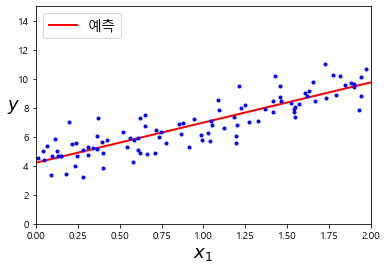

In [6]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="예측")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_) # 편향, 가중치
print(lin_reg.predict(X_new))

[4.21509616] [[2.77011339]]
[[4.21509616]
 [9.75532293]]


# 경사 하강법을 사용한 선형 회귀
- 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 매우 일반적인 최적화 알고리즘
- 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정

In [8]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # 무작위 초기화 . randn : 평균 0 표준편차 1 가우시안 표준 정규분포

for iteration in range(n_iterations) : 
    gradients = 2/m*X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * gradients
    
theta # 정규방정식과 같다.

array([[4.21509616],
       [2.77011339]])

## 학습률 바꾸기

In [9]:
theta_path_bgd=[]

def plot_gradient_descent(theta, eta, theta_path = None) :
    m = len(X_b)
    plt.plot(X,y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations) :
        if iteration <10 :
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration>0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m*X_b.T.dot(X_b.dot(theta) - y)
        theta = theta-eta*gradients
        if theta_path is not None :
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0,2,0,15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

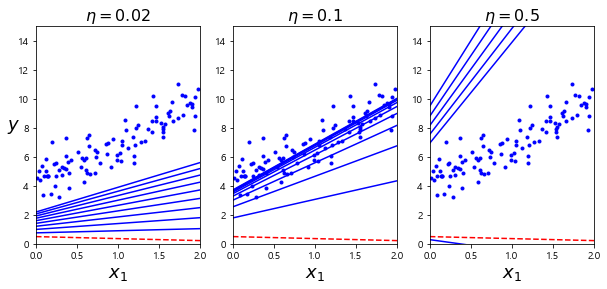

In [10]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize = (10,4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)

plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)

plt.show()

- 왼쪽은 학습률이 너무 낮다. 알고리즘은 최적점에 도달하겠지만 시간이 오래걸린다
- 가운데는 학습률이 아주 적당. 반복 몇 번 만에 이미 최적점에 수렴
- 오른쪽은 학습률이 너무 높다. 알고리즘이 이리저리 널뛰면서 스텝마다 최적점에서 점점 더 멀어져 발산한다.

        적절한 학습률을 찾으려면 그리드 탐색사용 (수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수를 제한한다.)

# 확률적 경사 하강법

In [11]:
theta_path_sgd=[]
m = len(X_b) # 훈련데이터에 있는 샘플수
np.random.seed(42)
m

100

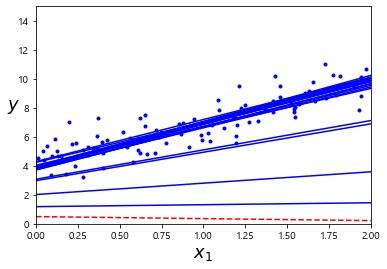

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케쥴 하이퍼파라미터

def learning_schedule(t) :
    return t0/(t+t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epochs) :
    for i in range(m) :
        if epoch == 0 and i <20 :
            y_predict = X_new_b.dot(theta)
            style = "b-" if i>0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index : random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        
plt.plot(X,y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$",rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

In [13]:
theta

array([[4.21076011],
       [2.74856079]])

SGDClassifier와 SGDRegressor은 에포크마다 모든 샘플을 사용하게 하기 위해 훈련 세트를 섞은 후 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법을 사용
- 단, 이렇게 하면 보통 더 늦게 수렴

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=50,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.23868557]), array([2.82181634]))

# 미니배치 경사 하강법
- 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그래디언트를 계산
- 장점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상이다.

책에 없어서 복붙

In [16]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 무작위 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
theta

array([[4.25214635],
       [2.7896408 ]])

In [17]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

In [18]:
theta_path_sgd.shape

(5000, 2, 1)

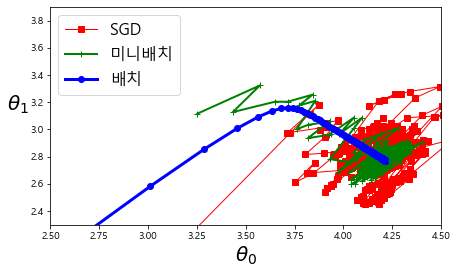

In [19]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="SGD")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="미니배치")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="배치")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

# 다항 회귀
- 비선형데이터를 학습하는 데 선형 모델 사용
- 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한

In [20]:
import numpy as np
import numpy.random as rnd
np.random.seed(42)

In [21]:
m = 100
X = 6*np.random.rand(m, 1) -3
y = 0.5*X**2 + X + 2 +np.random.randn(m,1) # 가우시안 잡음

In [22]:
X

array([[-0.75275929],
       [ 2.70428584],
       [ 1.39196365],
       [ 0.59195091],
       [-2.06388816],
       [-2.06403288],
       [-2.65149833],
       [ 2.19705687],
       [ 0.60669007],
       [ 1.24843547],
       [-2.87649303],
       [ 2.81945911],
       [ 1.99465584],
       [-1.72596534],
       [-1.9090502 ],
       [-1.89957294],
       [-1.17454654],
       [ 0.14853859],
       [-0.40832989],
       [-1.25262516],
       [ 0.67111737],
       [-2.16303684],
       [-1.24713211],
       [-0.80182894],
       [-0.26358009],
       [ 1.71105577],
       [-1.80195731],
       [ 0.08540663],
       [ 0.55448741],
       [-2.72129752],
       [ 0.64526911],
       [-1.97685526],
       [-2.60969044],
       [ 2.69331322],
       [ 2.7937922 ],
       [ 1.85038409],
       [-1.17231738],
       [-2.41396732],
       [ 1.10539816],
       [-0.35908504],
       [-2.26777059],
       [-0.02893854],
       [-2.79366887],
       [ 2.45592241],
       [-1.44732011],
       [ 0

In [23]:
y

array([[1.61761105],
       [8.06185944],
       [4.45250583],
       [0.77958493],
       [1.84625712],
       [2.42319555],
       [4.34161741],
       [6.09231611],
       [1.98223289],
       [3.52597398],
       [4.17601517],
       [9.12288507],
       [5.45422161],
       [2.27678027],
       [2.01026368],
       [2.87326073],
       [0.81318015],
       [1.8319083 ],
       [1.28292861],
       [0.06839479],
       [3.19243691],
       [2.43738261],
       [1.5356506 ],
       [1.28504875],
       [0.3557864 ],
       [4.75426637],
       [1.47885324],
       [1.28677651],
       [2.54692985],
       [3.38548344],
       [4.73964113],
       [2.15170091],
       [3.05310205],
       [8.24583537],
       [6.77765841],
       [5.53583085],
       [1.57507685],
       [4.9628939 ],
       [3.52398974],
       [2.00693334],
       [2.26890937],
       [0.80280214],
       [4.25144683],
       [8.22363289],
       [2.39107959],
       [2.54118912],
       [2.91120971],
       [0.725

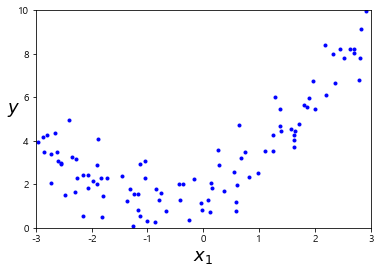

In [24]:
plt.plot(X,y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3,3,0,10])
plt.show()

### PolynomialFeatures를 사용해 훈련 데이터 변환
- 각 특성을 제곱하여 새로운 특성 추가

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias = False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


In [26]:
lin_reg=LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_
# y^ = 0.56x^2 + 0.93x + 1.78

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

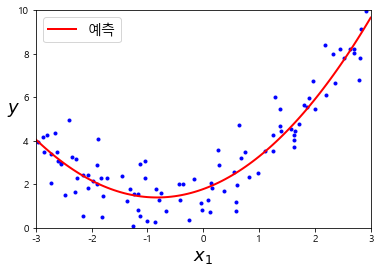

In [27]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="예측")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

# 학습곡선

책에 코드 없음

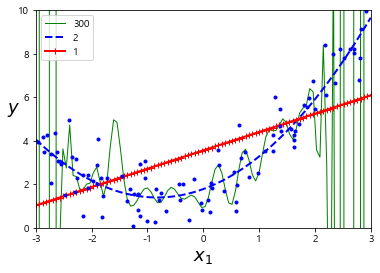

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

- 고차 다항 회귀 모델은 심각하게 훈련 데이터에 과대적합
- 선형 모델은 과소 적합
- 2차 다항 회귀는 가장 일반화가 잘된 모델
- 과대, 과소적합 아는 방법은 교차 검증을 통해 확인
   - 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘면 모델이 과대적합
   - 둘 다 모두 좋지 않으면 과소적합
- 또 다른 방법은 학습 곡선

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y) :
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)) :
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("훈련 세트 크기", fontsize=14)    
    plt.ylabel("RMSE", fontsize=14)      

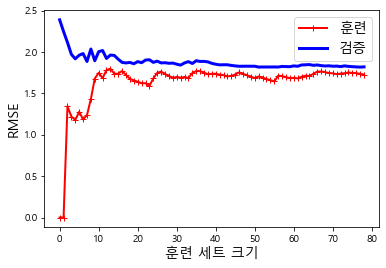

In [30]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.show()

#### 훈련 데이터
- 그래프가 0에서 시작하므로 훈련 세트에 하나 혹은 두 개의 샘플이 있을 땐 모델이 완벽하게 작동한다.
- 훈련 세트에 샘플이 추가됨에 따라 노이즈도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능하다.

#### 검증 데이터
- 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어서 검증 오차가 초기에 매우 큼
- 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소한다.
- 선형 회귀의 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워 진다.

==> 과소적합 모델의 전형적인 모습, 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있다.

### 10차 다항 회귀 모델의 학습 곡선

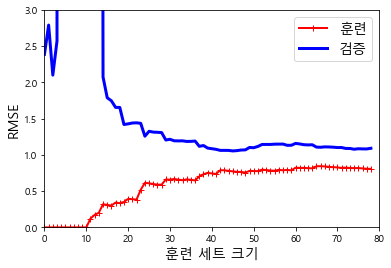

In [31]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

#### 이전 학습 곡선과의 차이점
- 훈련 데이터의 오차가 선형 회귀 모델보다 낮다.
- 두 곡선 사이에 공간이 있다. 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻, 이는 과대적합 모델의 특징, 하지만 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐

# 규제가 있는 모델
- 과대적합 감소시키는 좋은 방법
- 다항 회귀 모델 : 다항식 차수를 감소시키는 것
- 선형 회귀 모델 : 가중치 제한

## 릿지 회귀
- 규제가 추가된 선형 회귀 버전

책에 코드 없음

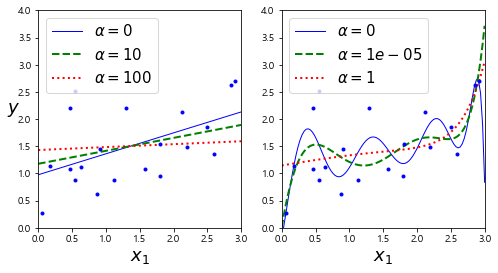

In [32]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

- 오른쪽 그래프는 PolynomialFeatures을 사용해 데이터를 확장
- StandardScaler를 사용해 스케일을 조정
- 릿지 모델 적용
- 알파를 증가시킬수록 직선에 가까워짐, 모델의 분산은 줄지만 편향은 커짐

### 정규방정식을 사용한 릿지 회귀(행렬 분해 사용)

In [33]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

### 확률적 경사 하강법을 사용한 릿지 회귀

In [34]:
sgd_reg = SGDRegressor(max_iter=5, penalty="l2") 
# penalty : 사용할 규제, l2는 SGD가 비용 함수에 가중치 벡터의 l2노름의 제곱을 2로 나눈 규제항을 추가하게 만듬, 즉 릿지회귀와 같다
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([1.12795912])

## 라쏘 회귀
- 릿지 회귀는 l2노름의 제곱을 2로 나눈 것
- 가중치 벡터의 l2 노름을 사용
- 덜 중요한 특성의 가중치를 완전히 제거하려고 함
- 자동으로 특성을 선택하고 희소 모델을 만듬

책에 코드 없음

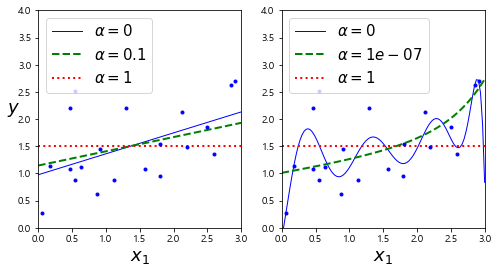

In [35]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [37]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# 편향은 무시
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

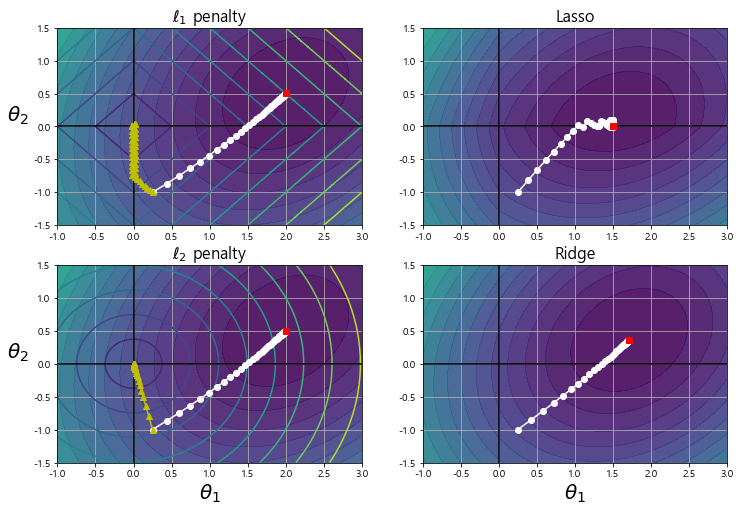

In [38]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0, labelpad=15)
    if i == 1: plt.xlabel(r"$\theta_1$", fontsize=20)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1: plt.xlabel(r"$\theta_1$", fontsize=20)

plt.show()

In [39]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## 엘라스틱넷
- 릿지 회귀와 라쏘 회귀를 절충한 모델
- 혼합 비율 r을 사용해 조절
- r=0이면 릿지회귀와 같고, r=1이면 라쏘회귀와 같다.

In [40]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 조기 종료
- 검증 에러가 최솟 값에 도달하면 바로 훈련을 중지시키는 것

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

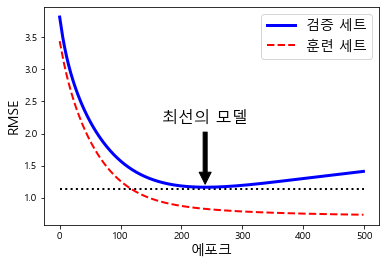

In [41]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('최선의 모델',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="훈련 세트")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("에포크", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [42]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 이어서 학습합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
D:\python\envs\tf_test\lib\site-packages\skl

In [43]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=True))

# 로지스틱 회귀
- 샘플이 특정 클래스에 속할 확률을 추정하는데 사용(이진분류기)

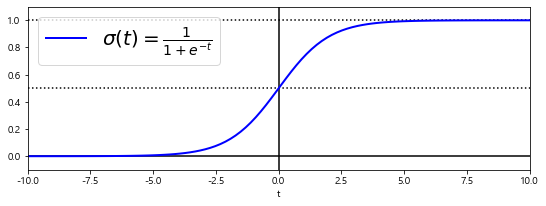

In [44]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

# 결정 경계

In [45]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [46]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [47]:
X = iris["data"][:, 3:] # 꽃잎의 넓이
y = (iris["target"] == 2).astype(np.int) # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [48]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = "liblinear", random_state = 42)
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

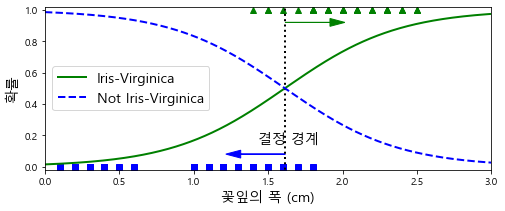

In [49]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:,1]>=0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "결정 경계", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("꽃잎의 폭 (cm)", fontsize=14)
plt.ylabel("확률", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [50]:
decision_boundary

array([1.61561562])

In [51]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

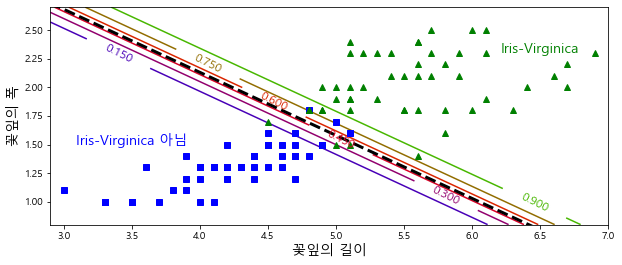

In [52]:
## 선형 결정 경계
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver='liblinear', C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Iris-Virginica 아님", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("꽃잎의 길이", fontsize=14)
plt.ylabel("꽃잎의 폭", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

- 꽃잎 너비와 꽃잎 길이 두 개의 특성으로 보여줌
- 점선은 모델이 50% 확률을 추정하는 지점으로 이 모델의 결정 경계이다.

# 소프트맥스 회귀(다중 로지스틱 회귀)
- 직접 다중 클래스를 지원하도록 일반화
- 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 sk(x)를 계산
- 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 롹률을 추정

In [53]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

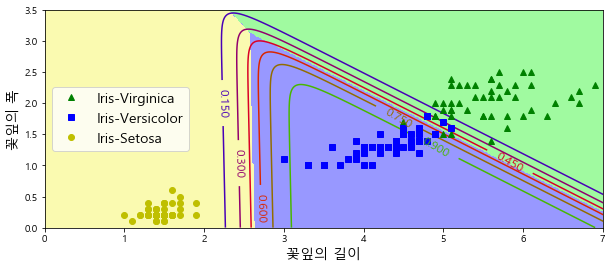

In [54]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("꽃잎의 길이", fontsize=14)
plt.ylabel("꽃잎의 폭", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [55]:
softmax_reg.predict([[5, 2]])

array([2])

In [56]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])